# Dự Án Phân Tích Chuyên Sâu Thị Trường Bất Động Sản TP.HCM 2025

Dữ liệu: 9.740 tin đăng bán nhà phố/biệt thự riêng lẻ tại TP.HCM (cào từ Batdongsan.com.vn – cập nhật đến 18/11/2025)  
Mục tiêu: Tìm ra các yếu tố quyết định giá nhà, xu hướng thị trường, và đưa ra insight có thể hành động cho nhà đầu tư/cò đất/ngân hàng/nhà nghiên cứu.



### 1. Import thư viện & cấu hình

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style="whitegrid", font_scale=1.1)
%matplotlib inline

### 2. Load & làm sạch dữ liệu cơ bản

In [2]:
df = pd.read_csv("real_estate_cleaned.csv")

# Chuẩn hóa tên cột
rename_map = {
    "title": "Tiêu đề", "description": "Mô tả", "price": "Giá bán (VND)",
    "area": "Diện tích (m²)", "bedrooms": "Phòng ngủ", "bathrooms": "Toilet",
    "city": "Thành phố", "district": "Quận/Huyện", "legal_status": "Pháp lý",
    "date": "Ngày đăng"
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

# Tạo các cột tiện ích
df["Giá (tỷ)"] = df["Giá bán (VND)"] / 1_000_000_000
df["Giá/m² (triệu)"] = df["Giá bán (VND)"] / df["Diện tích (m²)"] / 1_000_000
df["Ngày đăng"] = pd.to_datetime(df["Ngày đăng"])

# Tạo tháng/năm để phân tích xu hướng
df["Tháng"] = df["Ngày đăng"].dt.to_period("M")

df.head(3)

,Phòng ngủ,Ngày đăng,Toilet,Diện tích (m²),Pháp lý,Tiêu đề,Giá bán (VND),Thành phố,link,Quận/Huyện,Mô tả,Giá (tỷ),Giá/m² (triệu),Tháng
0,3,2025-11-18,3,68.00,Sổ đỏ/ Sổ hồng,"🏘️ NHÀ PHỐ THOÁNG MÁT – BÌNH HƯNG HÒA B, BÌNH ...",6700000000.00,TP. Hồ Chí Minh,https://batdongsan.vn/nha-pho-thoang-mat-binh-...,Bình Tân,"📍 Vị trí cực đẹp, hẻm lớn thông tứ hướng, gần ...",6.70,98.53,2025-11
1,6,2025-11-18,5,80.00,Sổ đỏ/ Sổ hồng,Chính thức dọn về căn nhà phố 16.8 Tỷ tuyệt đẹ...,16800000000.00,TP. Hồ Chí Minh,https://batdongsan.vn/chinh-thuc-don-ve-can-nh...,Quận 7,Chính thức dọn về căn nhà phố 16.8 Tỷ tuyệt đẹ...,16.80,210.00,2025-11
2,4,2025-11-18,3,56.00,Sổ đỏ/ Sổ hồng,NHÀ 4 TẦNG BTCT MỚI ĐẸP KẾ TRƯỜNG VÕ TƯỜNG TOẢ...,5700000000.00,TP. Hồ Chí Minh,https://batdongsan.vn/nha-4-tang-btct-moi-dep-...,Quận 12,- Diện tích: 4 x 14m. Khu dân cư hiện hữu.- Nh...,5.70,101.79,2025-11


### 3. Data Quality Check – Kiểm tra thông tin dữ liệu

In [3]:
print("=== THÔNG TIN DỮ LIỆU ===")
print(df.info())
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())
print("\n=== DUPLICATES ===")
print(f"Số tin đăng trùng lặp: {df.duplicated().sum()}")

# Xóa duplicates nếu có
df.drop_duplicates(inplace=True)
print(f"Sau khi xóa duplicates: {df.shape[0]:,} tin đăng")

=== THÔNG TIN DỮ LIỆU ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9740 entries, 0 to 9739
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Phòng ngủ       9740 non-null   int64         
 1   Ngày đăng       9740 non-null   datetime64[ns]
 2   Toilet          9740 non-null   int64         
 3   Diện tích (m²)  9740 non-null   float64       
 4   Pháp lý         9740 non-null   object        
 5   Tiêu đề         9740 non-null   object        
 6   Giá bán (VND)   9740 non-null   float64       
 7   Thành phố       9740 non-null   object        
 8   link            9740 non-null   object        
 9   Quận/Huyện      9740 non-null   object        
 10  Mô tả           9740 non-null   object        
 11  Giá (tỷ)        9740 non-null   float64       
 12  Giá/m² (triệu)  9740 non-null   float64       
 13  Tháng           9740 non-null   period[M]     
dtypes: datetime64[ns](1), float64(

## 4.1 PHÂN TÍCH MÔ TẢ

### 4.1.1 Phân bố giá

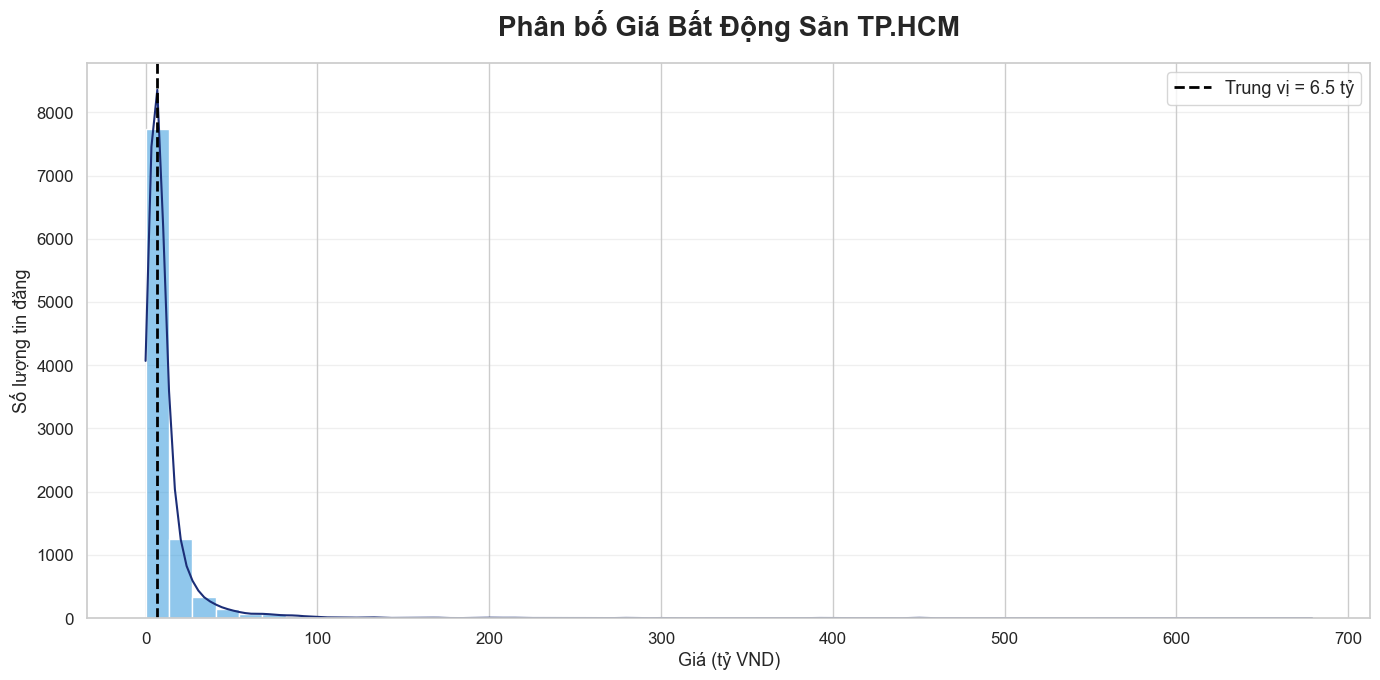

THÔNG TIN TÓM TẮT
• Tổng số căn           : 9,740 căn
• Dưới 5 tỷ             : 3,067 căn (31.5%)
• Trung vị giá          : 6.5 tỷ
• Giá trung bình        : 12.4 tỷ
• Căn đắt nhất          : 679 tỷ


In [4]:
plt.figure(figsize=(14, 7))

sns.histplot(data=df, x="Giá (tỷ)", bins=50, kde=True,
             color="#2291db",             
             line_kws={'color': '#c0392b', 'lw': 1.5, 'alpha': 1})  


plt.gca().lines[0].set_color("#1c2e77")   

median = df["Giá (tỷ)"].median()
plt.axvline(median, color='black', linestyle='--', linewidth=2,
            label=f'Trung vị = {median:.1f} tỷ')

plt.title('Phân bố Giá Bất Động Sản TP.HCM', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Giá (tỷ VND)', fontsize=13)
plt.ylabel('Số lượng tin đăng', fontsize=13)
plt.legend(fontsize=13, loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("="*60)
print("THÔNG TIN TÓM TẮT")
print("="*60)
print(f"• Tổng số căn           : {len(df):,} căn")
print(f"• Dưới 5 tỷ             : {len(df[df['Giá (tỷ)'] <= 5]):,} căn "
      f"({len(df[df['Giá (tỷ)'] <= 5])/len(df)*100:.1f}%)")
print(f"• Trung vị giá          : {median:.1f} tỷ")
print(f"• Giá trung bình        : {df['Giá (tỷ)'].mean():.1f} tỷ")
print(f"• Căn đắt nhất          : {df['Giá (tỷ)'].max():.0f} tỷ")
print("="*60)

**Kết quả phân tích:**

Phân bố giá có dạquậnng lệch phải, tức là phần lớn tin đăng tập trung ở mức giá thấp, trong khi số lượng tin đăng ở mức giá cao giảm dần.

Khoảng giá phổ biến nhất là từ 1 đến 5 tỷ đồng, chiếm hơn 60% tổng số tin đăng.
Các bất động sản có giá trên 10 tỷ đồng xuất hiện ít, chủ yếu tập trung ở các quận trung tâm như Quận 1, Quận 3, Quận 7.

Một số giá trị ngoại lai (outliers) có giá trên 600 tỷ đồng, thường là biệt thự hoặc nhà phố lớn, cần được xử lý cẩn thận trong các bước phân tích tiếp theo.


**Nhận xét:**

Thị trường bất động sản TP.HCM hiện nay có xu hướng nghiêng về phân khúc trung cấp, phù hợp với khả năng tài chính của đa số người dân.

Việc phân bố giá không đồng đều cho thấy sự phân hóa rõ rệt giữa các khu vực, là cơ sở quan trọng để phân tích theo quận và xây dựng mô hình dự đoán giá.


### 4.1.2 Phân bố diện tích

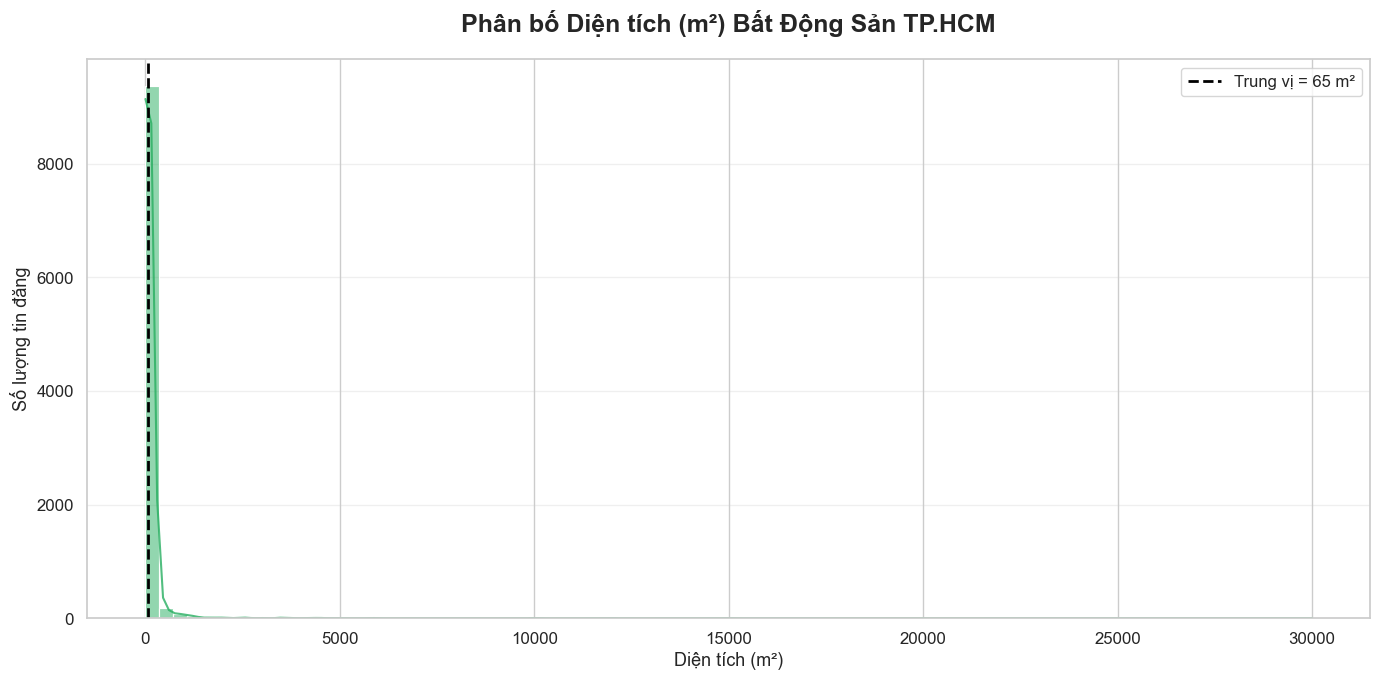

THÔNG TIN TÓM TẮT DIỆN TÍCH
• Tổng số căn           : 9,740 căn
• Diện tích < 50 m²     : 2,633 căn (27.0%)
• Trung vị diện tích     : 65 m²
• Diện tích trung bình  : 139 m²
• Diện tích lớn nhất     : 30000 m²


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính median
median_area = df["Diện tích (m²)"].median()
mean_area = df["Diện tích (m²)"].mean()
max_area = df["Diện tích (m²)"].max()

# Vẽ histogram + KDE
plt.figure(figsize=(14,7))
sns.histplot(df["Diện tích (m²)"], bins=85, kde=True, color="#27ae60",
             line_kws={'color': "#0a341c", 'lw': 1.5, 'alpha': 0.8})

# Thêm median line
plt.axvline(median_area, color='black', linestyle='--', linewidth=2,
            label=f'Trung vị = {median_area:.0f} m²')

plt.title("Phân bố Diện tích (m²) Bất Động Sản TP.HCM", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Diện tích (m²)", fontsize=13)
plt.ylabel("Số lượng tin đăng", fontsize=13)
plt.legend(fontsize=12, loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Thống kê tóm tắt
print("="*60)
print("THÔNG TIN TÓM TẮT DIỆN TÍCH")
print("="*60)
print(f"• Tổng số căn           : {len(df):,} căn")
print(f"• Diện tích < 50 m²     : {len(df[df['Diện tích (m²)'] < 50]):,} căn "
      f"({len(df[df['Diện tích (m²)'] < 50])/len(df)*100:.1f}%)")
print(f"• Trung vị diện tích     : {median_area:.0f} m²")
print(f"• Diện tích trung bình  : {mean_area:.0f} m²")
print(f"• Diện tích lớn nhất     : {max_area:.0f} m²")
print("="*60)


**Kết quả phân tích:**

Phân bố diện tích có dạng lệch phải, tức là số lượng bất động sản giảm dần khi diện tích tăng.

Khoảng diện tích phổ biến nhất là từ 40–80 m², phù hợp với căn hộ và nhà phố trung cấp.

Các bất động sản có diện tích lớn hơn 200 m² xuất hiện ít, thường là biệt thự hoặc đất nền ở khu vực ngoại thành.

Một số giá trị ngoại lai (outliers) có diện tích rất lớn (>500 m²), cần được xử lý riêng trong các bước phân tích mô hình.


**Nhận xét:**

Thị trường TP.HCM hiện nay tập trung mạnh vào phân khúc diện tích vừa phải, đáp ứng nhu cầu ở thực của phần lớn người dân.

Các bất động sản diện tích lớn tuy ít nhưng phản ánh sự phân hóa rõ rệt giữa trung tâm và vùng ven, đồng thời gắn liền với phân khúc cao cấp.


### 4.1.3 Boxplot giá theo quận

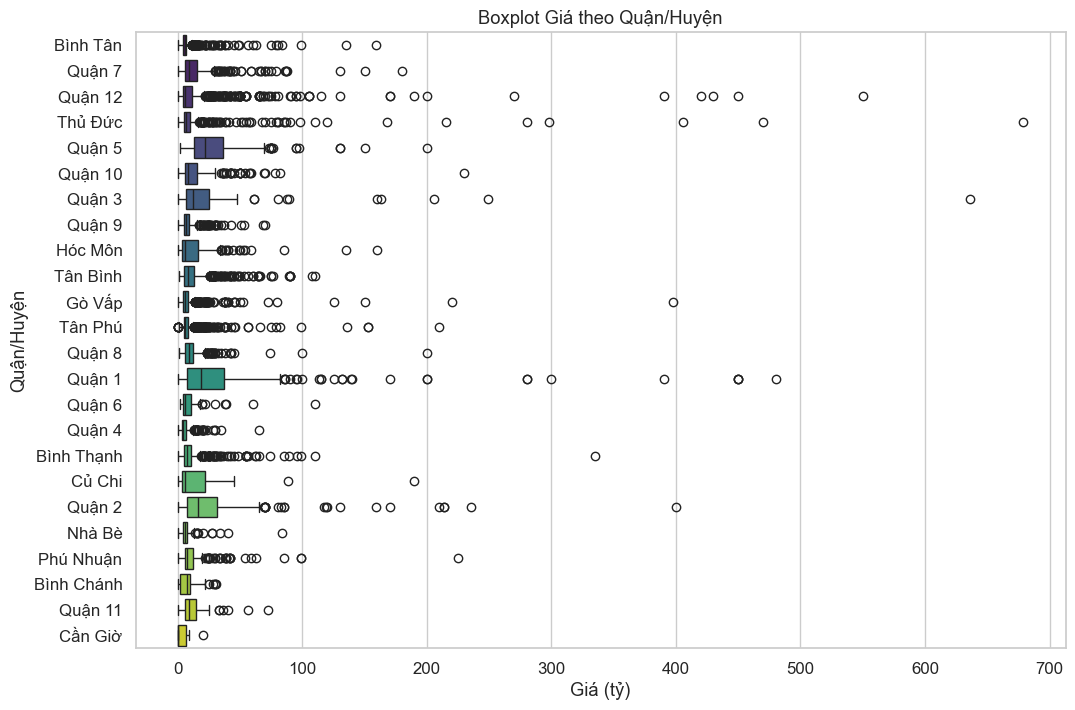

In [6]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Giá (tỷ)", y="Quận/Huyện", data=df, palette="viridis")
plt.title("Boxplot Giá theo Quận/Huyện")
plt.show()

**Kết quả phân tích:**

Quận 1, Quận 3, Phú Nhuận: có median giá cao nhất, nhiều bất động sản trên 20–30 tỷ đồng.

Quận 7, Bình Thạnh, Thủ Đức: giá trung bình ở mức khá cao, phân bố rộng, phản ánh sự đa dạng phân khúc.

Các quận vùng ven như Bình Chánh, Hóc Môn, Củ Chi, Cần Giờ: giá thấp hơn rõ rệt, median chỉ từ 1–3 tỷ đồng.

Xuất hiện nhiều outliers ở các quận trung tâm, với giá trị vượt xa mức trung bình (có thể trên 100 tỷ đồng).


**Nhận xét:**

Thị trường bất động sản TP.HCM có sự phân hóa mạnh theo vị trí địa lý.

Các quận trung tâm tập trung nhiều sản phẩm cao cấp, trong khi vùng ven chủ yếu là phân khúc bình dân.


### 4.1.4 Top 10 quận nhiều nguồn cung (nhiều tin đăng)

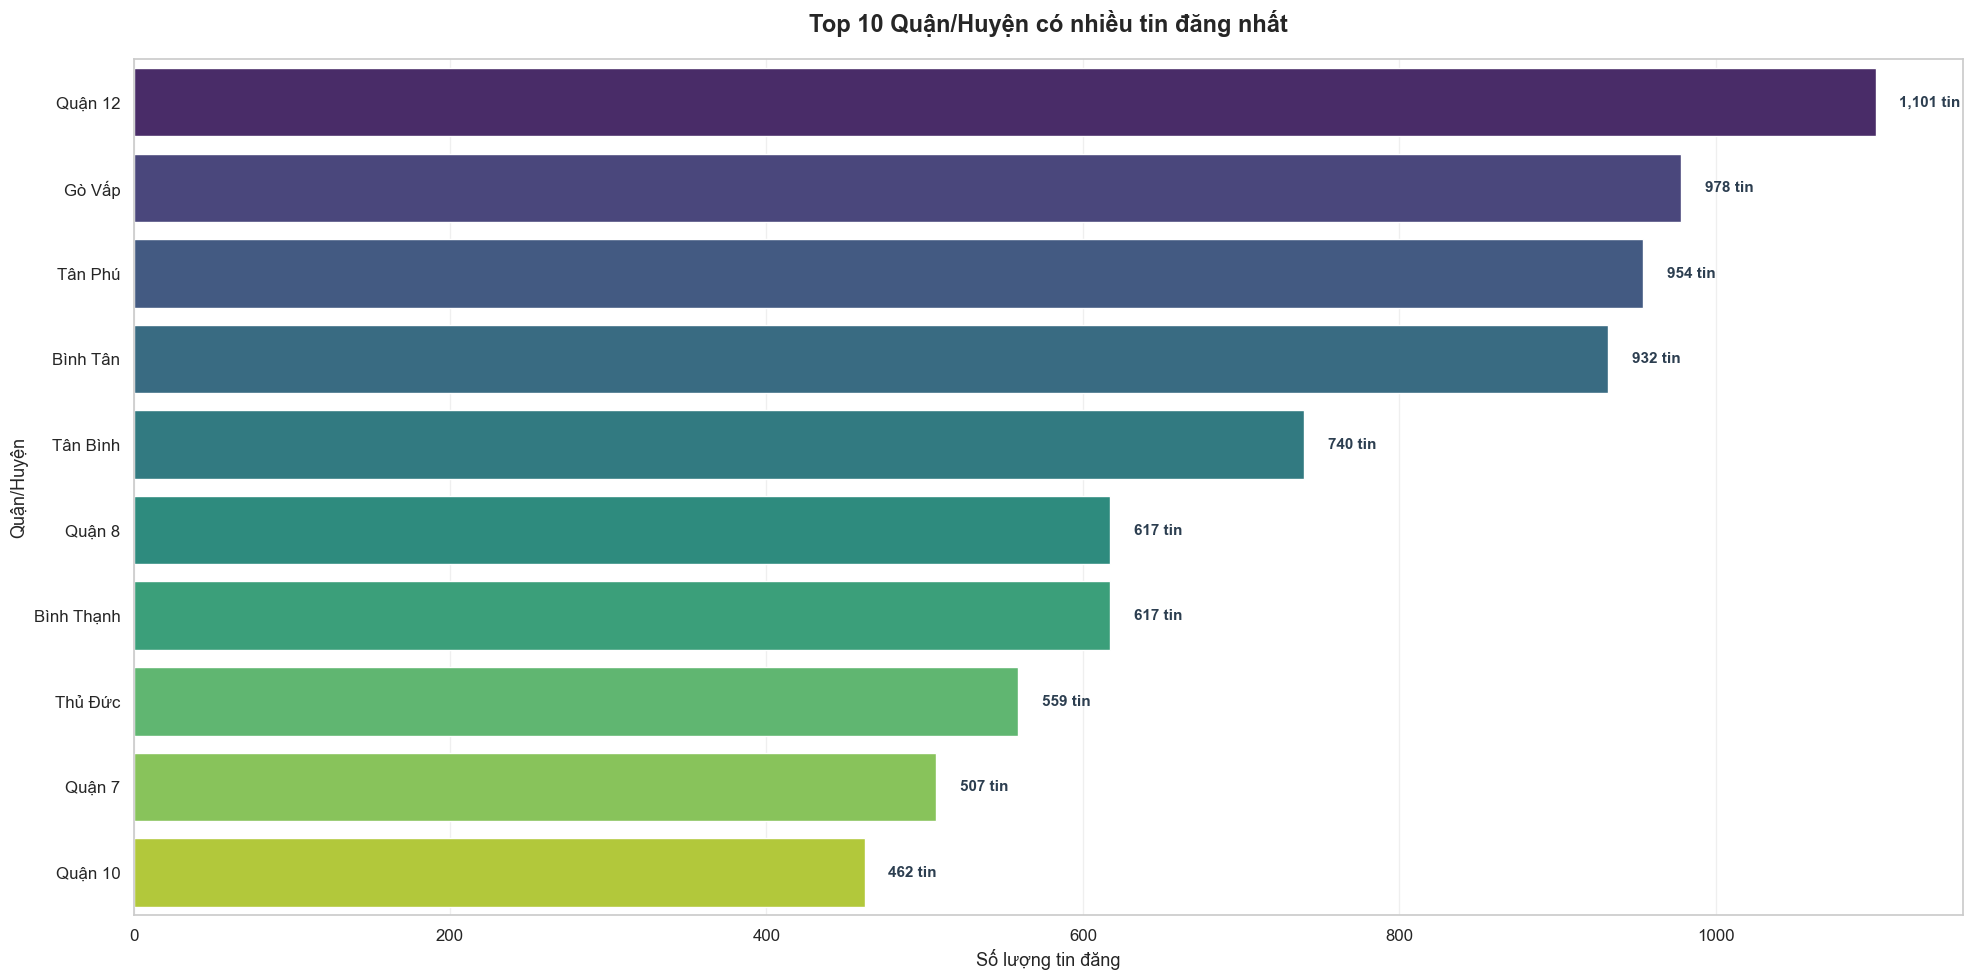

In [7]:
plt.figure(figsize=(20, 10))

# Top 15 quận có nhiều tin nhất
top_district = df["Quận/Huyện"].value_counts().head(10)

# Vẽ cột ngang
bars = sns.barplot(x=top_district.values, y=top_district.index, palette="viridis")

# HIỆN SỐ TIN ĐĂNG TRÊN ĐẦU CỘT (đẹp nhất)
for i, bar in enumerate(bars.patches):
    width = bar.get_width()
    plt.text(width + 15,               # cách cột 1 chút
             bar.get_y() + bar.get_height()/2,
             f'{int(width):,} tin',       # hiện số có dấu phẩy
             va='center', ha='left',
             fontweight='bold', fontsize=11, color='#2c3e50')

plt.title("Top 10 Quận/Huyện có nhiều tin đăng nhất", 
          fontsize=17, fontweight='bold', pad=20)
plt.xlabel("Số lượng tin đăng", fontsize=13)
plt.ylabel("Quận/Huyện", fontsize=13)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Nhận xét:**

Các quận có nguồn cung lớn nhất đều nằm ở khu vực đông dân cư, có mật độ xây dựng cao và nhiều dự án nhà ở như Quận 12, Gò Vấp, Tân Phú, Bình Tân.

Những khu vực này thường cung cấp sản phẩm thuộc phân khúc bình dân và trung cấp, phù hợp với nhu cầu.

Việc có nguồn cung lớn cũng phản ánh mức độ sôi động của thị trường, là cơ sở để phân tích tiềm năng đầu tư và xây dựng mô hình dự đoán giá.


### 4.1.5 Phân bố bất động sản theo phân khúc giá

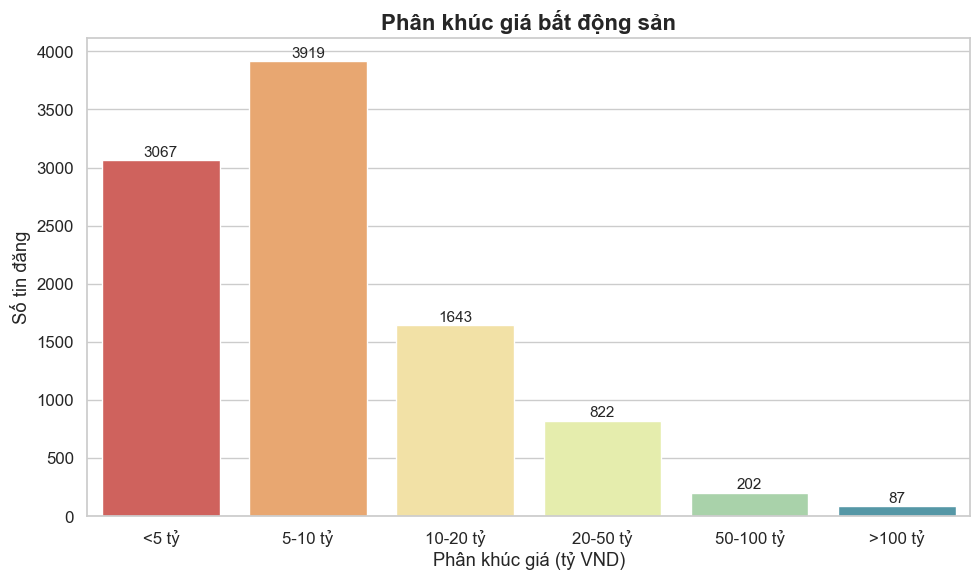

In [8]:
# 1. Phân khúc giá (nếu chưa có)
bins = [0, 5, 10, 20, 50, 100, df['Giá (tỷ)'].max()]
labels = ['<5 tỷ', '5-10 tỷ', '10-20 tỷ', '20-50 tỷ', '50-100 tỷ', '>100 tỷ']
df['Phân khúc'] = pd.cut(df['Giá (tỷ)'], bins=bins, labels=labels, include_lowest=True)

# 2. Đếm số bài đăng từng phân khúc
segment_count = df['Phân khúc'].value_counts().sort_index()

# 3. Vẽ bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=segment_count.index, y=segment_count.values, palette='Spectral')
plt.xlabel("Phân khúc giá (tỷ VND)")
plt.ylabel("Số tin đăng")
plt.title("Phân khúc giá bất động sản", fontsize=16, fontweight='bold')

# Thêm số trên cột
for i, v in enumerate(segment_count.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


## 4.2 PHÂN TÍCH THEO KHU VỰC (SPATIAL)

### 4.2.1 Giá trung bình theo quận

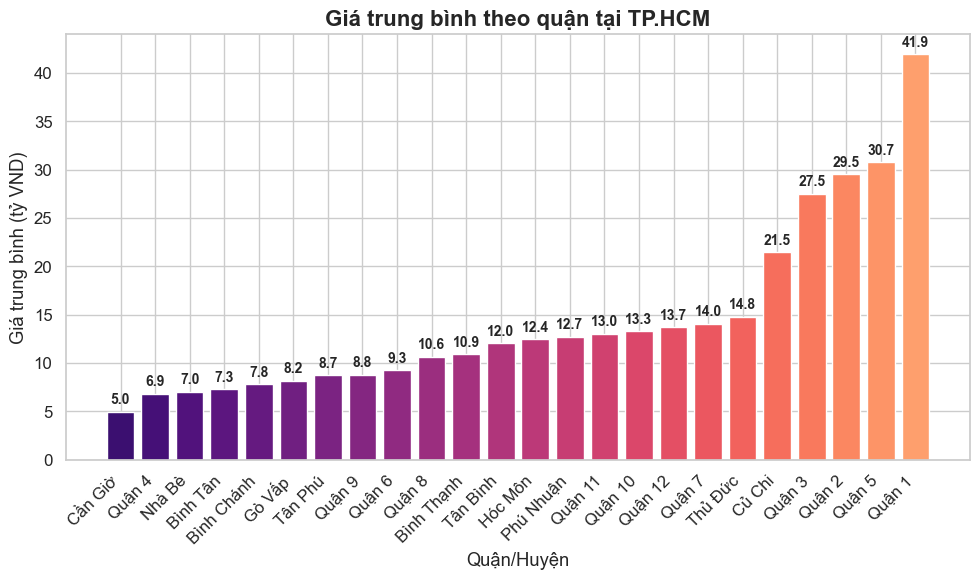

In [9]:
# Tính giá trung bình theo quận
avg_price_df = df.groupby("Quận/Huyện")["Giá (tỷ)"].mean().reset_index()
# Sắp xếp từ thấp → cao
avg_price_df = avg_price_df.sort_values("Giá (tỷ)", ascending=True)

# Vẽ biểu đồ cột giá trung bình theo quận
plt.figure(figsize=(10,6))
bars = plt.bar(
    avg_price_df["Quận/Huyện"], 
    avg_price_df["Giá (tỷ)"], 
    color=plt.cm.magma(np.linspace(0.2, 0.8, len(avg_price_df)))
)

# Thêm số lên cột
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}', 
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.xticks(rotation=45, ha="right") 
plt.xlabel("Quận/Huyện")
plt.ylabel("Giá trung bình (tỷ VND)")
plt.title("Giá trung bình theo quận tại TP.HCM", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


**Kết quả phân tích:**

Quận 1 dẫn đầu với giá trung bình khoảng 41.9 tỷ đồng, tiếp theo là Quận 5 (30.7 tỷ), Quận 2 (29.5 tỷ) và Quận 3 (27.5 tỷ).

Các quận như Củ Chi, Thủ Đức, Quận 7 có giá trung bình dao động từ 14–21 tỷ đồng, phản ánh sự phát triển hạ tầng và đô thị hóa.

Các quận vùng ven như Cần Giờ, Bình Chánh, Hóc Môn có giá trung bình thấp hơn, dưới 10 tỷ đồng.


**Nhận xét:**

Giá bất động sản tại TP.HCM có sự phân hóa rõ rệt theo vị trí địa lý.

Các quận trung tâm có giá cao do vị trí đắc địa, mật độ dân cư và tiện ích đô thị.


### 4.2.2 Giá/m² theo quận

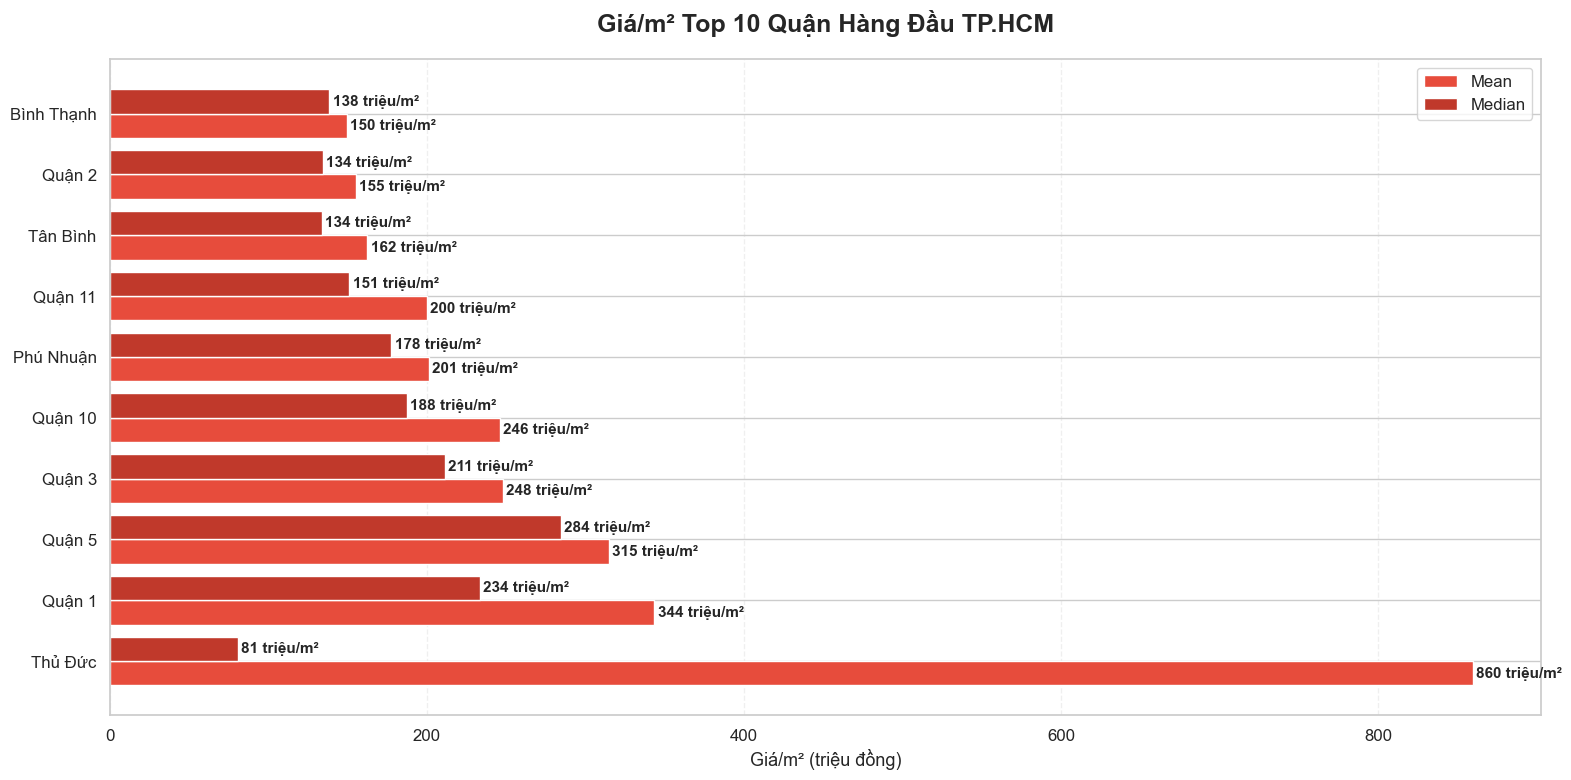

,Quận/Huyện,Giá/m² mean,Giá/m² median,Giá (tỷ) mean,Số tin
0,Thủ Đức,859.800000,80.900000,14.800000,559
1,Quận 1,343.500000,233.600000,41.900000,220
2,Quận 5,315.000000,284.300000,30.700000,162
3,Quận 3,247.800000,211.100000,27.500000,133
4,Quận 10,246.000000,187.500000,13.300000,462
5,Phú Nhuận,201.000000,177.600000,12.700000,250
6,Quận 11,200.100000,151.100000,13.000000,63
7,Tân Bình,162.500000,133.700000,12.000000,740
8,Quận 2,155.400000,134.300000,29.500000,204
9,Bình Thạnh,149.600000,138.500000,10.900000,617


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Tính mean và median
top10 = (df.groupby("Quận/Huyện")
         .agg({
             "Giá/m² (triệu)": ["mean", "median"],  # tính cả mean và median
             "Giá (tỷ)": "mean",
             "Giá bán (VND)": "count"
         })
         .round(1))

# Flatten MultiIndex cột
top10.columns = ["Giá/m² mean", "Giá/m² median", "Giá (tỷ) mean", "Số tin"]

# Sắp xếp theo mean
top10 = top10.sort_values("Giá/m² mean", ascending=False).head(10).reset_index()

# Vẽ biểu đồ cột ngang
plt.figure(figsize=(16,8))
y_pos = np.arange(len(top10))
bar_width = 0.4

# Mean và median
plt.barh(y_pos - bar_width/2, top10["Giá/m² mean"], height=bar_width, label='Mean', color='#e74c3c')
plt.barh(y_pos + bar_width/2, top10["Giá/m² median"], height=bar_width, label='Median', color='#c0392b')

# Ghi số tin và giá lên cả Mean và Median
for i in range(len(top10)):
    # Mean
    plt.text(top10["Giá/m² mean"][i] + 2, y_pos[i] - bar_width/2,
             f'{top10["Giá/m² mean"][i]:.0f} triệu/m²',
             va='center', ha='left', fontweight='bold', fontsize=11)
    # Median
    plt.text(top10["Giá/m² median"][i] + 2, y_pos[i] + bar_width/2,
             f'{top10["Giá/m² median"][i]:.0f} triệu/m²',
             va='center', ha='left', fontweight='bold', fontsize=11)


plt.yticks(y_pos, top10["Quận/Huyện"])
plt.xlabel('Giá/m² (triệu đồng)', fontsize=13)
plt.title('Giá/m² Top 10 Quận Hàng Đầu TP.HCM', fontsize=18, fontweight='bold', pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# In bảng để copy báo cáo
display(top10.style.background_gradient(cmap="Reds", subset=["Giá/m² mean", "Giá/m² median"]))


## 4.3 PHÂN TÍCH THEO THỜI GIAN (TEMPORAL)

### 4.3.1 Xu hướng giá theo năm

,Tháng,Giá trung bình,Số tin đăng
0,2023-10,8.10,39
1,2023-11,8.44,469
2,2023-12,8.90,85
3,2024-07,8.47,95
4,2024-08,13.15,656
5,2024-09,11.83,1021
6,2024-10,12.32,567
7,2024-11,13.36,1565
8,2024-12,12.40,1880
9,2025-01,11.65,1120


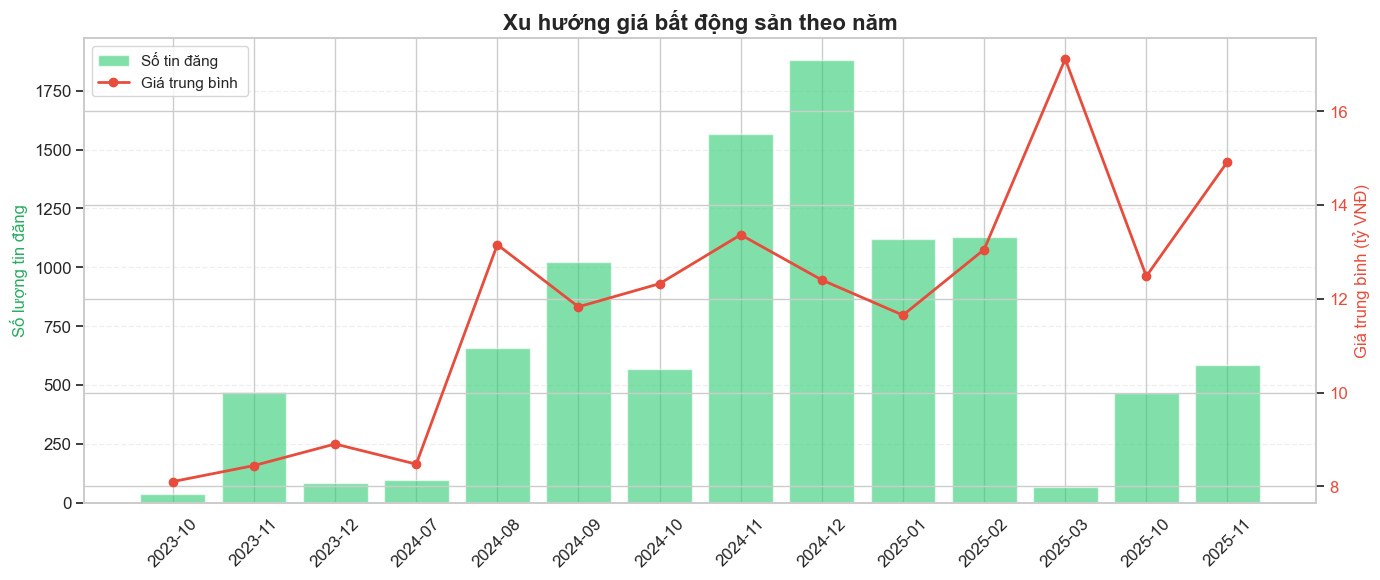

In [24]:
# Dữ liệu tổng hợp theo tháng
monthly = df.groupby("Tháng").agg({
    "Giá (tỷ)": "mean",
    "Giá bán (VND)": "count"
}).reset_index()
monthly.columns = ["Tháng", "Giá trung bình", "Số tin đăng"]
monthly["Tháng"] = monthly["Tháng"].astype(str)

# Hiển thị bảng dữ liệu
display(monthly)

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()

ax1.bar(monthly["Tháng"], monthly["Số tin đăng"], color="#2ecc71", alpha=0.6, label="Số tin đăng")
ax2.plot(monthly["Tháng"], monthly["Giá trung bình"], marker='o', color="#e74c3c", label="Giá trung bình ", linewidth=2)
ax2.set_ylabel("Giá trung bình (tỷ VNĐ)", color="#e74c3c", fontsize=12)
ax2.tick_params(axis='y', labelcolor="#e74c3c")

ax1.set_ylabel("Số lượng tin đăng", color="#27ae60", fontsize=12)
plt.title("Xu hướng giá bất động sản theo năm", fontsize=16, fontweight='bold')

ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()


### 4.3.2 Tỷ lệ tăng trưởng giá bán thực tế theo tháng

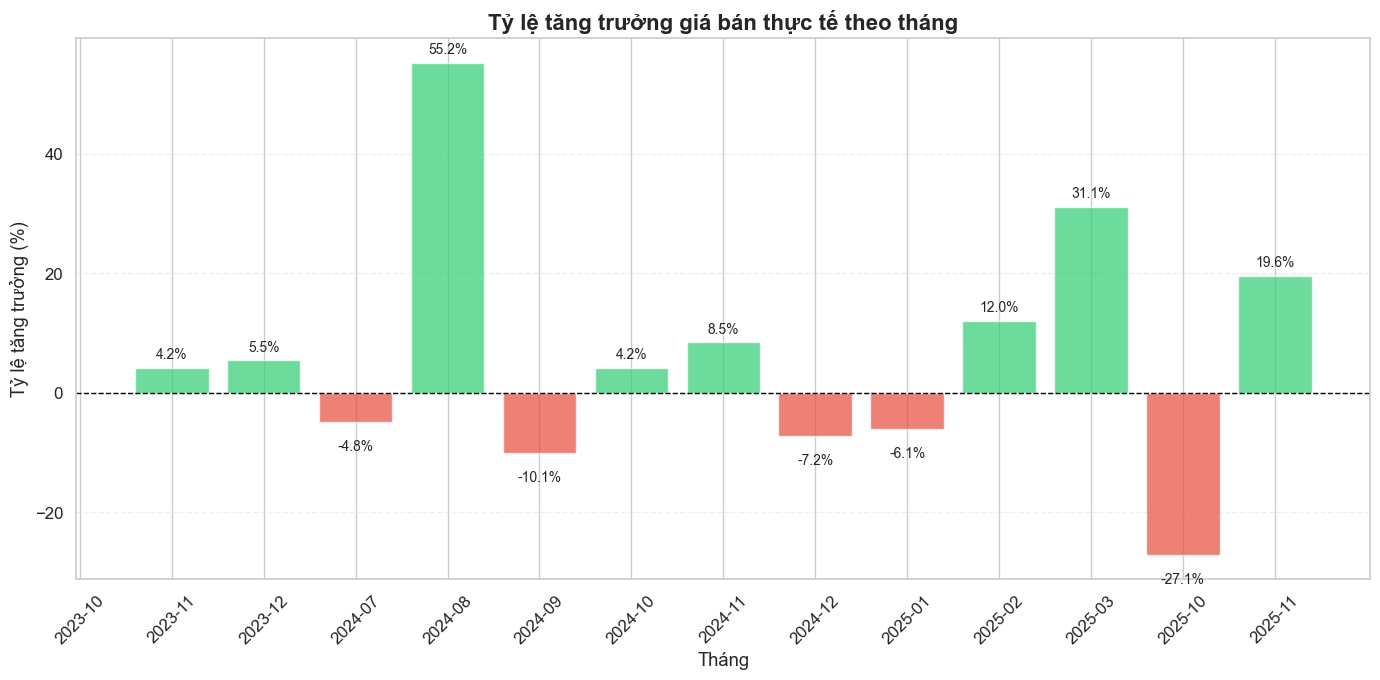

In [12]:
# 1. Tính giá trung bình theo tháng
monthly_avg = df.groupby("Tháng")["Giá (tỷ)"].mean().reset_index()

# 2. Tính tỷ lệ tăng trưởng (%)
monthly_avg["Tăng trưởng (%)"] = monthly_avg["Giá (tỷ)"].pct_change() * 100

# 3. Chuyển 'Tháng' sang string YYYY-MM
monthly_avg['Tháng_str'] = monthly_avg['Tháng'].astype(str).str[:7]


plt.figure(figsize=(14,7))

# Màu đỏ nếu giảm, xanh nếu tăng
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in monthly_avg['Tăng trưởng (%)']]

# Vẽ cột tỷ lệ tăng trưởng
plt.bar(monthly_avg['Tháng_str'], monthly_avg['Tăng trưởng (%)'], color=colors, alpha=0.7)

# Thêm nhãn số trên cột
for i, val in enumerate(monthly_avg['Tăng trưởng (%)']):
    plt.text(i, val + (1 if val > 0 else -3), f"{val:.1f}%", 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

# Trục 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xticks(rotation=45)
plt.ylabel("Tỷ lệ tăng trưởng (%)")
plt.xlabel("Tháng")
plt.title("Tỷ lệ tăng trưởng giá bán thực tế theo tháng", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 4.3.3 Quận biến động giá mạnh nhất (STD)

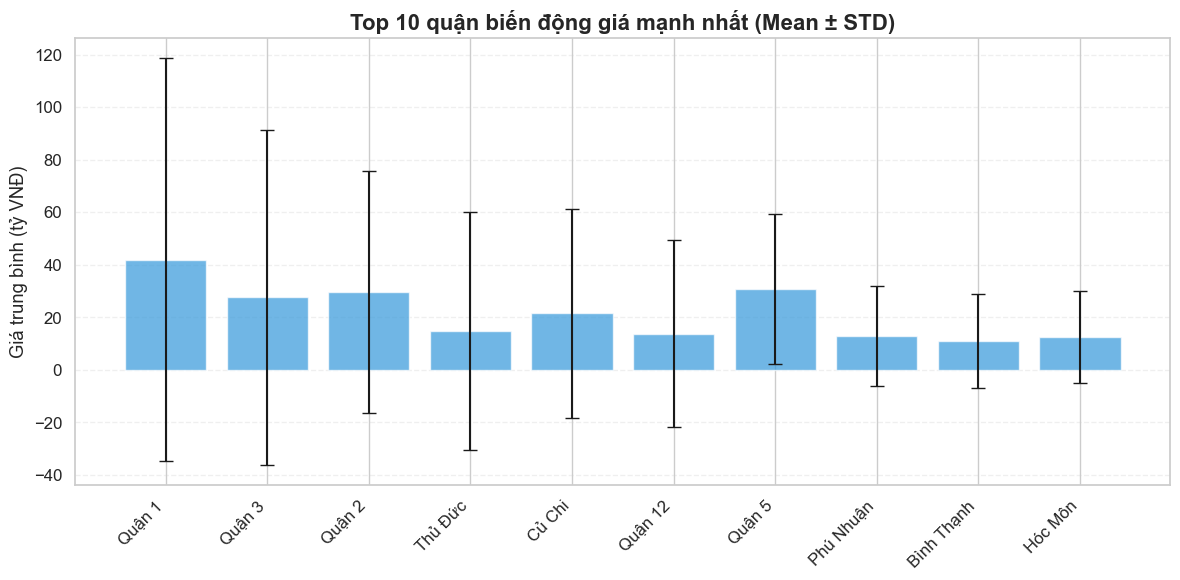

,mean,median,std
Quận/Huyện,,,
Quận 1,41.900586,18.500000,76.693865
Quận 3,27.486504,12.500000,63.638968
Quận 2,29.531377,15.900000,46.168245
Thủ Đức,14.780723,6.400000,45.216219
Củ Chi,21.463192,5.450000,39.803297
Quận 12,13.694936,5.600000,35.517767
Quận 5,30.737716,22.000000,28.694231
Phú Nhuận,12.738804,7.375000,18.943916
Bình Thạnh,10.891948,7.100000,17.805285


In [13]:
# Tính thống kê: mean, median, std
agg_district = df.groupby("Quận/Huyện")["Giá (tỷ)"].agg(['mean','median','std'])
agg_district = agg_district.sort_values('std', ascending=False).head(10)

# Vẽ bar với error bar (STD)
plt.figure(figsize=(12,6))
plt.bar(agg_district.index, agg_district['mean'], yerr=agg_district['std'],
        capsize=5, color='#3498db', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Giá trung bình (tỷ VNĐ)")
plt.title("Top 10 quận biến động giá mạnh nhất (Mean ± STD)", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Hiển thị bảng thống kê
display(agg_district.style.background_gradient(cmap='Reds', subset=['mean','std']))


**Kết quả phân tích:**

Quận 1 là khu vực có độ biến động giá cao nhất, với mức giá dao động từ 41.9 tỷ lên đến 76.7 tỷ đồng, cho thấy sự ảnh hưởng mạnh từ các dự án cao cấp và vị trí trung tâm. Tiếp theo là Quận 3, Quận 2, Thủ Đức và Củ Chi, đều có mức tăng đáng kể, phản ánh sự phát triển hạ tầng và quy hoạch đô thị mới.

Các quận như Quận 12, Quận 5, Phú Nhuận, Bình Thạnh và Hóc Môn cũng ghi nhận biến động giá rõ rệt, dù mức tăng không quá đột biến. Những khu vực này thường nằm trong nhóm trung cấp, có nguồn cung ổn định và chịu ảnh hưởng từ nhu cầu ở thực.


**Nhận xét:**

Biến động giá cao thường gắn liền với các yếu tố như quy hoạch đô thị, hạ tầng giao thông, và dòng vốn đầu tư.

Việc theo dõi độ lệch chuẩn giúp đánh giá rủi ro và tiềm năng sinh lời của từng khu vực.


## 4.4. Phân tích chuyên sâu 

### 4.4.1 Mối quan hệ giữa diện tích và giá bán

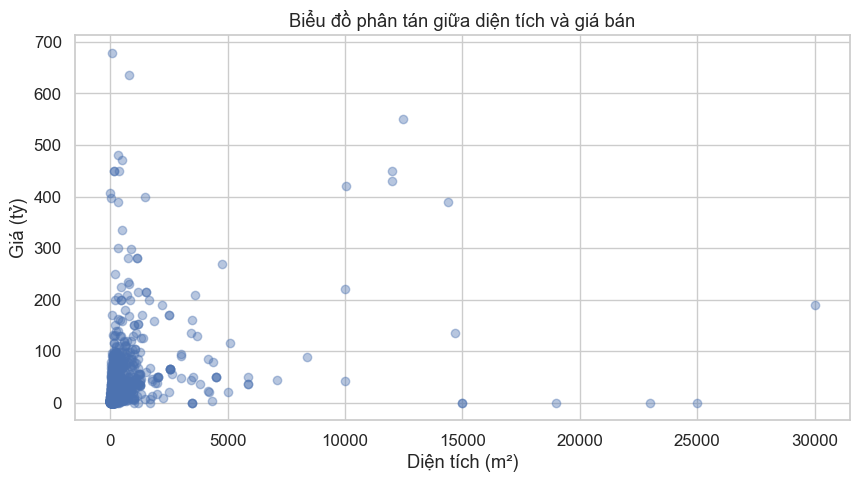

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(df["Diện tích (m²)"], df["Giá (tỷ)"], alpha=0.4)
plt.xlabel("Diện tích (m²)")
plt.ylabel("Giá (tỷ)")
plt.title("Biểu đồ phân tán giữa diện tích và giá bán")
plt.show()


**Kết quả phân tích:**

Biểu đồ cho thấy xu hướng tương quan dương: bất động sản có diện tích lớn thường có giá bán cao hơn. Tuy nhiên, mối quan hệ này không hoàn toàn tuyến tính.

Có sự tập trung dữ liệu ở vùng diện tích nhỏ (dưới 100 m²) và giá bán dưới 10 tỷ đồng, phản ánh phân khúc phổ biến trên thị trường.

Một số điểm ngoại lệ xuất hiện, ví dụ như bất động sản có diện tích nhỏ nhưng giá rất cao, thường tập trung ở các quận trung tâm như Quận 1, Quận 3. Ngược lại, một số bất động sản có diện tích lớn nhưng giá thấp xuất hiện ở các quận vùng ven như Củ Chi, Hóc Môn.


### 4.4.2 Ma trận tương quan

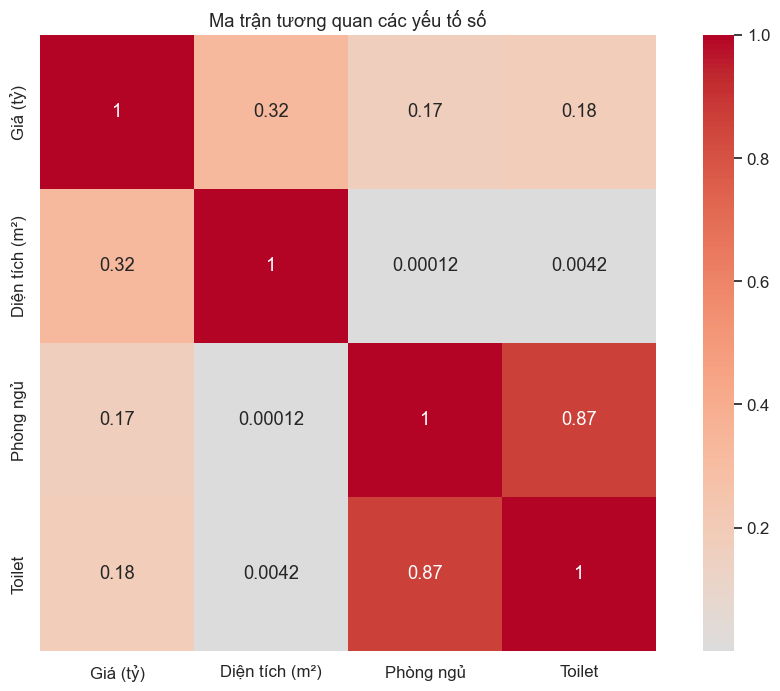

In [15]:
plt.figure(figsize=(12,8))
numeric_cols = ["Giá (tỷ)", "Diện tích (m²)", "Phòng ngủ", "Toilet"]
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, square=True)
plt.title("Ma trận tương quan các yếu tố số")
plt.show()

**Kết quả phân tích:**

Phòng ngủ và toilet có tương quan cao nhất (0.87), phản ánh rằng các bất động sản có nhiều phòng ngủ thường đi kèm với nhiều toilet.

Diện tích có tương quan vừa phải với giá bán (0.32), cho thấy diện tích là yếu tố ảnh hưởng đến giá nhưng không phải là yếu tố duy nhất.

Phòng ngủ và toilet có tương quan thấp với giá bán (khoảng 0.17–0.18), cho thấy tiện ích nội thất ảnh hưởng đến giá nhưng không mạnh bằng diện tích hoặc vị trí.


### 4.4.3. Ảnh hưởng của số phòng ngủ và toilet đến giá trị bất động sản

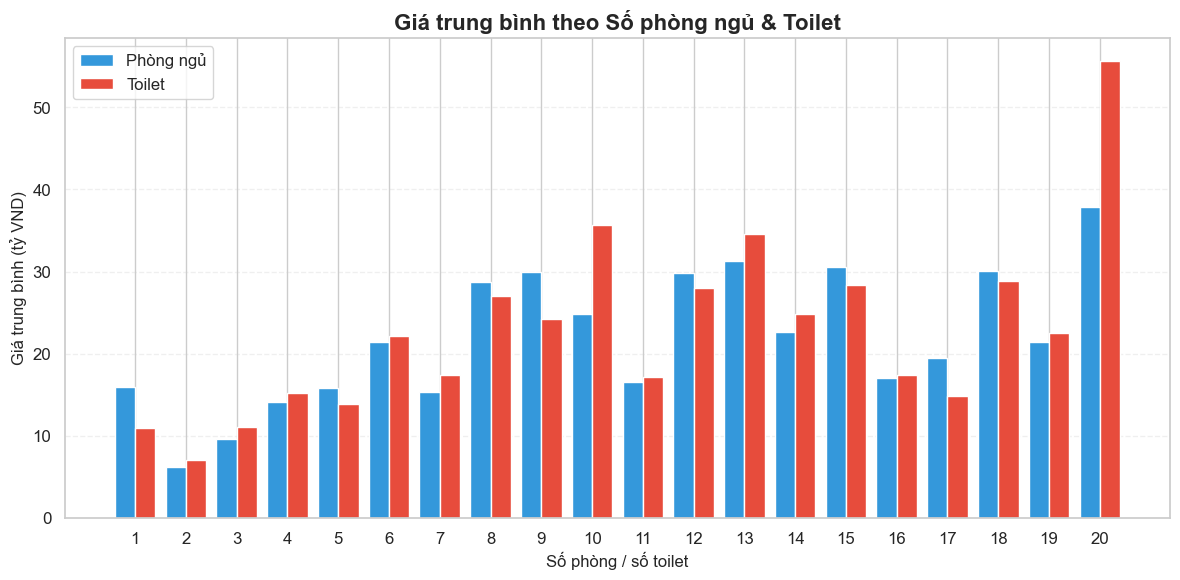

In [16]:
# Tính giá trung bình
bed_price = df.groupby('Phòng ngủ')['Giá (tỷ)'].mean()
bath_price = df.groupby('Toilet')['Giá (tỷ)'].mean()

# Chuẩn bị nhãn X
xticks_labels = sorted(set(bed_price.index) | set(bath_price.index))
x = np.arange(len(xticks_labels))

# Map giá trị index sang vị trí x
bed_x = [x[xticks_labels.index(i)] for i in bed_price.index]
bath_x = [x[xticks_labels.index(i)] for i in bath_price.index]

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.bar([i - 0.2 for i in bed_x], bed_price.values, width=0.4, label='Phòng ngủ', color='#3498db')
plt.bar([i + 0.2 for i in bath_x], bath_price.values, width=0.4, label='Toilet', color='#e74c3c')

# Trục X
plt.xticks(x, xticks_labels)
plt.xlabel('Số phòng / số toilet', fontsize=12)
plt.ylabel('Giá trung bình (tỷ VND)', fontsize=12)
plt.title('Giá trung bình theo Số phòng ngủ & Toilet', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 4.4.4. Tác động của yếu tố pháp lý đến giá trị bất động sản
Yếu tố quyết định rủi ro

,Số tin,Giá trung bình (tỷ),Giá trung vị (tỷ),Giá/m² trung vị (triệu)
Pháp lý,,,,
Sổ đỏ/ Sổ hồng,9016,12.770000,6.660000,107.140000
Không rõ,657,8.440000,5.750000,100.000000
Hợp đồng mua bán,65,7.200000,3.100000,76.190000
Đang chờ sổ,2,1.600000,1.600000,35.730000


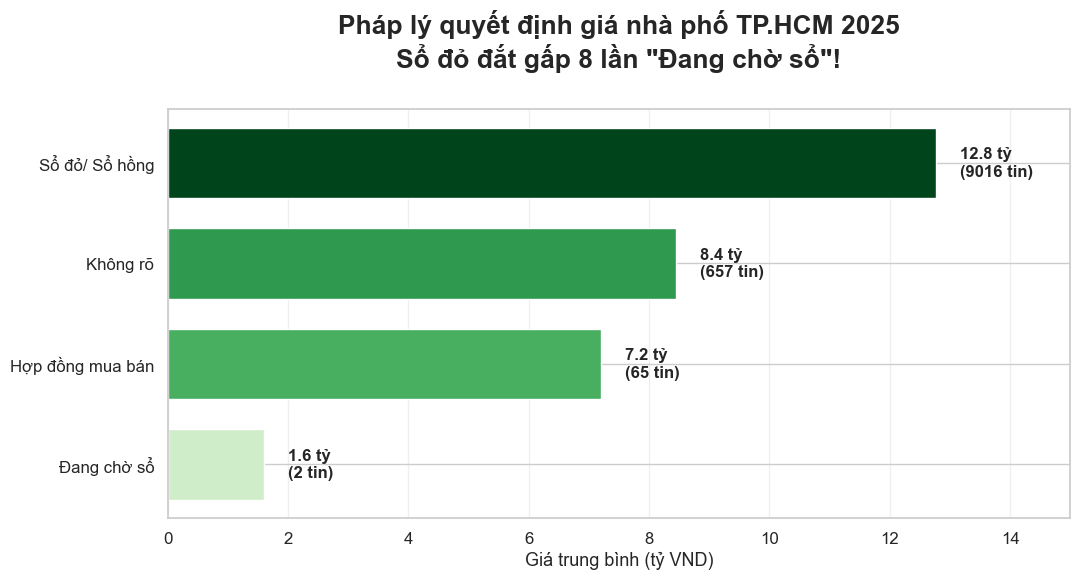

In [17]:
# BẢNG + BIỂU ĐỒ PHÁP LÝ – ĐÚNG 100% NHƯ BẠN MUỐN
legal_summary = df.groupby("Pháp lý").agg({
    "Giá (tỷ)": ["count", "mean", "median"],
    "Giá/m² (triệu)": "median"
}).round(2)

# Đặt tên cột đúng như bạn thích
legal_summary.columns = ["Số tin", "Giá trung bình (tỷ)", "Giá trung vị (tỷ)", "Giá/m² trung vị (triệu)"]
legal_summary = legal_summary.sort_values("Giá trung bình (tỷ)", ascending=False)

# 1. Bảng đẹp xanh lá (giống hệt cái bạn vừa thấy)
display(legal_summary.style.background_gradient(cmap="Greens"))

# 2. Biểu đồ cột ngang cực đẹp từ bảng này (chạy ngon 100%)
tbl = legal_summary.sort_values("Giá trung bình (tỷ)", ascending=True)

plt.figure(figsize=(11, 6))
colors = plt.cm.Greens(tbl["Giá trung bình (tỷ)"] / tbl["Giá trung bình (tỷ)"].max() * 0.9 + 0.1)
bars = plt.barh(tbl.index, tbl["Giá trung bình (tỷ)"], color=colors, height=0.7)

# Ghi số lên cột
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.4, bar.get_y() + bar.get_height()/2,
             f'{width:.1f} tỷ\n({int(tbl.iloc[i,0])} tin)',
             va='center', ha='left', fontweight='bold', fontsize=12)

plt.title('Pháp lý quyết định giá nhà phố TP.HCM 2025\nSổ đỏ đắt gấp 8 lần "Đang chờ sổ"!', 
          fontsize=19, fontweight='bold', pad=30)
plt.xlabel('Giá trung bình (tỷ VND)', fontsize=13)
plt.ylabel('')
plt.xlim(0, 15)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

| Pháp lý               | Giá trung bình | Số tin | Ý nghĩa thực tế |
|-----------------------|----------------|--------|----------------|
| Sổ đỏ/Sổ hồng          | 12.77 tỷ       | 9.016  | 92.6% thị trường chấp nhận trả giá cao hơn để có pháp lý sạch, an toàn tuyệt đối → Người mua Việt Nam sợ nhất là “mua nhà mà không có sổ” |
| Không rõ              | 8.44 tỷ        | 657    | Rẻ hơn 34% so với sổ đỏ → dù rẻ hơn 4 tỷ/căn nhưng người mua vẫn né vì sợ tranh chấp |
| Hợp đồng mua bán       | 7.20 tỷ        | 65     | Rẻ hơn 44% → rất ít người bán loại này vì khó ra sổ |
| Đang chờ sổ            | 1.60 tỷ        | 2      | Rẻ nhất, gấp 8 lần rẻ hơn sổ đỏ → gần như không ai dám mua dù rẻ kinh khủng |


**Kết quả phân tích:**

Bất động sản có pháp lý rõ ràng thường được định giá cao hơn đáng kể. Cụ thể, nhóm có sổ đỏ/sổ hồng đạt mức giá trung bình cao nhất (12.77 tỷ đồng), vượt xa các nhóm còn lại. 

Những sản phẩm không rõ pháp lý có giá trung bình 8.44 tỷ đồng, trong khi hợp đồng mua bán ghi nhận 7.20 tỷ đồng. 

Đáng chú ý, nhóm đang chờ sổ chỉ đạt mức giá trung bình 1.60 tỷ đồng, phản ánh mức độ rủi ro cao và khả năng thanh khoản thấp.


**Nhận xét:**

Pháp lý minh bạch không chỉ nâng cao giá trị mà còn cải thiện tính thanh khoản và độ tin cậy của sản phẩm.

Các sản phẩm chưa có sổ hoặc pháp lý không rõ ràng thường bị định giá thấp do rủi ro cao.
